In [239]:
import numpy as np

def generalized_HF(mol, conv_tol = 1e-5):

    n_a = mol.nelec[0]
    n_b = mol.nelec[1]
    ntot = n_a + n_b


    T = mol.intor("int1e_kin") # this is in spatial orbital format; need to convert to spinorbital.

    norb = np.shape(T)[0]

    Vnuc = mol.intor("int1e_nuc")
    hcore = T+Vnuc

    S = mol.intor("int1e_ovlp")
    h2e = mol.intor('int2e', aosym = "s1")

    hcore_ab = np.zeros((2*norb,2*norb))
    hcore_ab[:norb,:norb] = hcore
    hcore_ab[norb:,norb:] = hcore

    S_ab = np.zeros((2*norb,2*norb))
    S_ab[:norb,:norb] = S
    S_ab[norb:,norb:] = S

    h2e_ab = np.zeros((2*norb,2*norb,2*norb,2*norb))
    h2e_ab[:norb,:norb,:norb,:norb] = h2e
    h2e_ab[norb:,norb:,norb:,norb:] = h2e
    h2e_ab[:norb,:norb,norb:,norb:] = h2e
    h2e_ab[norb:,norb:,:norb,:norb] = h2e

    s, U = np.linalg.eigh(S_ab)
    s_inv_sqrt = np.diag([x**(-0.5) for x in s])
    X = U @ s_inv_sqrt @ U.conj().T

    F0 = X.T @ hcore_ab @ X

    # initial guess

    # _, C0 = np.linalg.eigh(F0)
    # C = X @ C0
    # P = C[:,:ntot] @ C[:,:ntot].conj().T

    P = np.random.rand(2*norb,2*norb) # the guess matters a LOT because if you choose a UHF guess, you'll never have off-diag. Fock matrix elements.
    
    conv = 10
    Eprev = None

    while conv>conv_tol:
        F = hcore_ab + np.einsum('ij,ijkl->kl',P, h2e_ab) - np.einsum('ij,kijl->kl',P,h2e_ab)
        print(F)
        E0 = 0.5*(np.einsum('ij,ji->',P, hcore_ab) + np.einsum('ij,ji->',P, F))
        print(E0 + mol.energy_nuc())
        if Eprev is not None:
            conv = np.abs(E0-Eprev)
        if conv<conv_tol:
            break

        Eprev = E0

        Fp = X.conj().T @ F @ X
        eps, Cp = np.linalg.eigh(Fp)

        C = X @ Cp

        P = C[:,:ntot] @ C[:,:ntot].conj().T
    
    E0 = E0 + mol.energy_nuc()

    # i think this is a correct implementation  of generalized HF? unsure. it seems like the energies are always going to be very close to
    # whatever UHF gives...


    return E0, P, F, C


In [288]:
import numpy as np
import scipy as sp
import pyscf
from pyscf import gto, scf

mol = gto.Mole()
mol.atom = """
H    0.0    0.0    0.0
H    1.0    0.0    0.0
H    0.5    0.866    0.0
"""
mol.basis = '6-31g'
mol.charge = 0
mol.spin = 3
mol.build()

In [277]:
mf = scf.UHF(mol)
mf.kernel()

converged SCF energy = -481.455430895643  <S^2> = 3.7500997  2S+1 = 4.0000499


-481.45543089564256

In [278]:
np.shape(mf.mo_energy)
print(mf.mo_energy)

[[-4.06655007e+01 -4.06557010e+01 -4.06551025e+01 -4.07694840e+00
  -3.09312660e+00 -3.08587839e+00 -2.24536959e+00 -2.23860361e+00
  -2.16073044e+00 -2.15780159e+00 -1.78497554e+00 -1.78018810e+00
  -1.47620637e+00 -1.38776572e+00 -1.38597078e+00 -3.44286765e-01
  -2.27626148e-01 -1.94387466e-01 -2.01598199e-02  4.25111719e-02
   5.58616117e-02  5.73726527e-02  5.78157916e-02  6.15032821e-02
   6.94766544e-02  7.00092935e-02  9.89963135e-02  1.05210603e-01
   1.31023575e-01  1.79389929e-01  1.79928207e-01  1.89977152e-01
   1.94643734e-01  2.03496395e-01  2.07079119e-01  2.65619804e-01
   3.32428831e-01  1.68251397e+00  1.68300787e+00]
 [-4.06613459e+01 -4.06505089e+01 -4.06499172e+01 -4.07264069e+00
  -3.08478409e+00 -3.07520420e+00 -2.23001569e+00 -2.22755838e+00
  -2.15160912e+00 -2.14808402e+00 -1.77673028e+00 -1.77102079e+00
  -1.47024336e+00 -1.38117726e+00 -1.37575750e+00 -1.27315639e-02
   2.30502443e-02  3.95591184e-02  4.62492551e-02  6.78455220e-02
   7.78568582e-02  7.8232

In [283]:
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -481.455336911518


-481.4553369115185

In [284]:
import pyscf.cc
mycc = cc.ccd.CCD(mf)

mycc.kernel()

CCD not converged
E(CCD) = -481.5756262405282  E_corr = -0.1202893290093573


(-0.12028932900935727,
 array([[[[-5.16658075e-06, -1.77979692e-06,  2.36120791e-12, ...,
            2.17987396e-13,  4.52625016e-05, -4.21958287e-11],
          [-1.77979692e-06, -7.25618026e-08,  9.47607238e-13, ...,
           -7.17459811e-13,  2.30049622e-05, -2.77024047e-11],
          [ 2.36120791e-12,  9.47607238e-13,  1.59283881e-07, ...,
           -1.77227891e-07, -2.44948852e-11, -4.09069120e-06],
          ...,
          [ 2.17987396e-13, -7.17459811e-13, -1.77227891e-07, ...,
            3.16462902e-07,  9.67319963e-12, -1.23334252e-06],
          [ 4.52625016e-05,  2.30049622e-05, -2.44948852e-11, ...,
            9.67319963e-12, -4.10899208e-04,  4.41829702e-10],
          [-4.21958287e-11, -2.77024047e-11, -4.09069120e-06, ...,
           -1.23334252e-06,  4.41829702e-10, -2.88518453e-05]],
 
         [[-4.32522686e-13, -4.21862821e-12,  3.43810695e-08, ...,
            1.56566780e-09,  2.06688367e-11, -7.23966099e-07],
          [-3.79107737e-12, -2.70630242e-13, -1.2

In [289]:
mol.nao

6

In [290]:
mol.nelec

(3, 0)

In [261]:
mf.mo_coeff

array([[ 2.04271444e-01, -1.60134290e-01,  1.95352734e-01,
        -7.47551859e-02,  9.59193272e-02, -1.12728299e-01,
         4.76323661e-01, -4.09047746e-01, -6.76871624e-01,
         3.95635281e-01,  4.78082733e-01,  6.95420892e-01],
       [ 1.43545618e-01, -8.51695880e-02,  7.67865542e-01,
        -4.73964495e-01,  5.06191297e-01, -8.75606084e-01,
        -3.84251560e-01,  2.86136776e-01,  9.44196357e-01,
        -5.10620991e-01, -5.55223381e-01, -8.45244483e-01],
       [ 2.04271444e-01, -1.60134290e-01, -1.95352734e-01,
        -7.47551860e-02,  9.59193272e-02,  1.12728299e-01,
         4.76323661e-01, -4.09047746e-01,  6.76871624e-01,
         3.95635281e-01,  4.78082733e-01, -6.95420892e-01],
       [ 1.43545618e-01, -8.51695880e-02, -7.67865542e-01,
        -4.73964495e-01,  5.06191297e-01,  8.75606084e-01,
        -3.84251560e-01,  2.86136776e-01, -9.44196357e-01,
        -5.10620991e-01, -5.55223381e-01,  8.45244483e-01],
       [ 1.63147132e-01, -2.45108630e-01, -2.4081792

In [291]:
soln = generalized_HF(mol)

[[ 8.34884505  3.25805747  0.41915142  1.19091025  0.17980554  1.10117972
  -3.40620588 -3.42902876 -2.37403232 -3.07148893 -2.4479787  -3.0517817 ]
 [ 3.24323748  4.5220186   1.28115283  2.8293274   0.93871557  2.72006705
  -3.28375669 -3.79515336 -2.81531005 -3.60240481 -3.02359518 -3.62989397]
 [ 0.30317449  1.23078907  8.56764257  3.36482187  0.08066985  1.14016466
  -2.29158762 -2.81842149 -3.05109541 -3.11761759 -2.33131286 -2.84068641]
 [ 1.18927796  2.86601311  3.42656664  4.63562727  0.91009719  2.77502964
  -2.92359263 -3.56473335 -3.0560752  -3.67554286 -2.99868615 -3.56893713]
 [ 0.21010471  0.95439137  0.07533555  0.88408792  7.68473761  2.86685455
  -2.49070082 -3.0325669  -2.22481014 -2.92959023 -3.38203781 -3.3335917 ]
 [ 1.14819499  2.76034112  1.19348286  2.76111153  2.88130288  4.38227544
  -3.01149505 -3.65094619 -2.77239991 -3.57162086 -3.36514789 -3.78930099]
 [-3.03583488 -3.01473361 -2.14264587 -2.70686836 -2.35898162 -2.77614219
   8.36588263  3.52661928  0.509

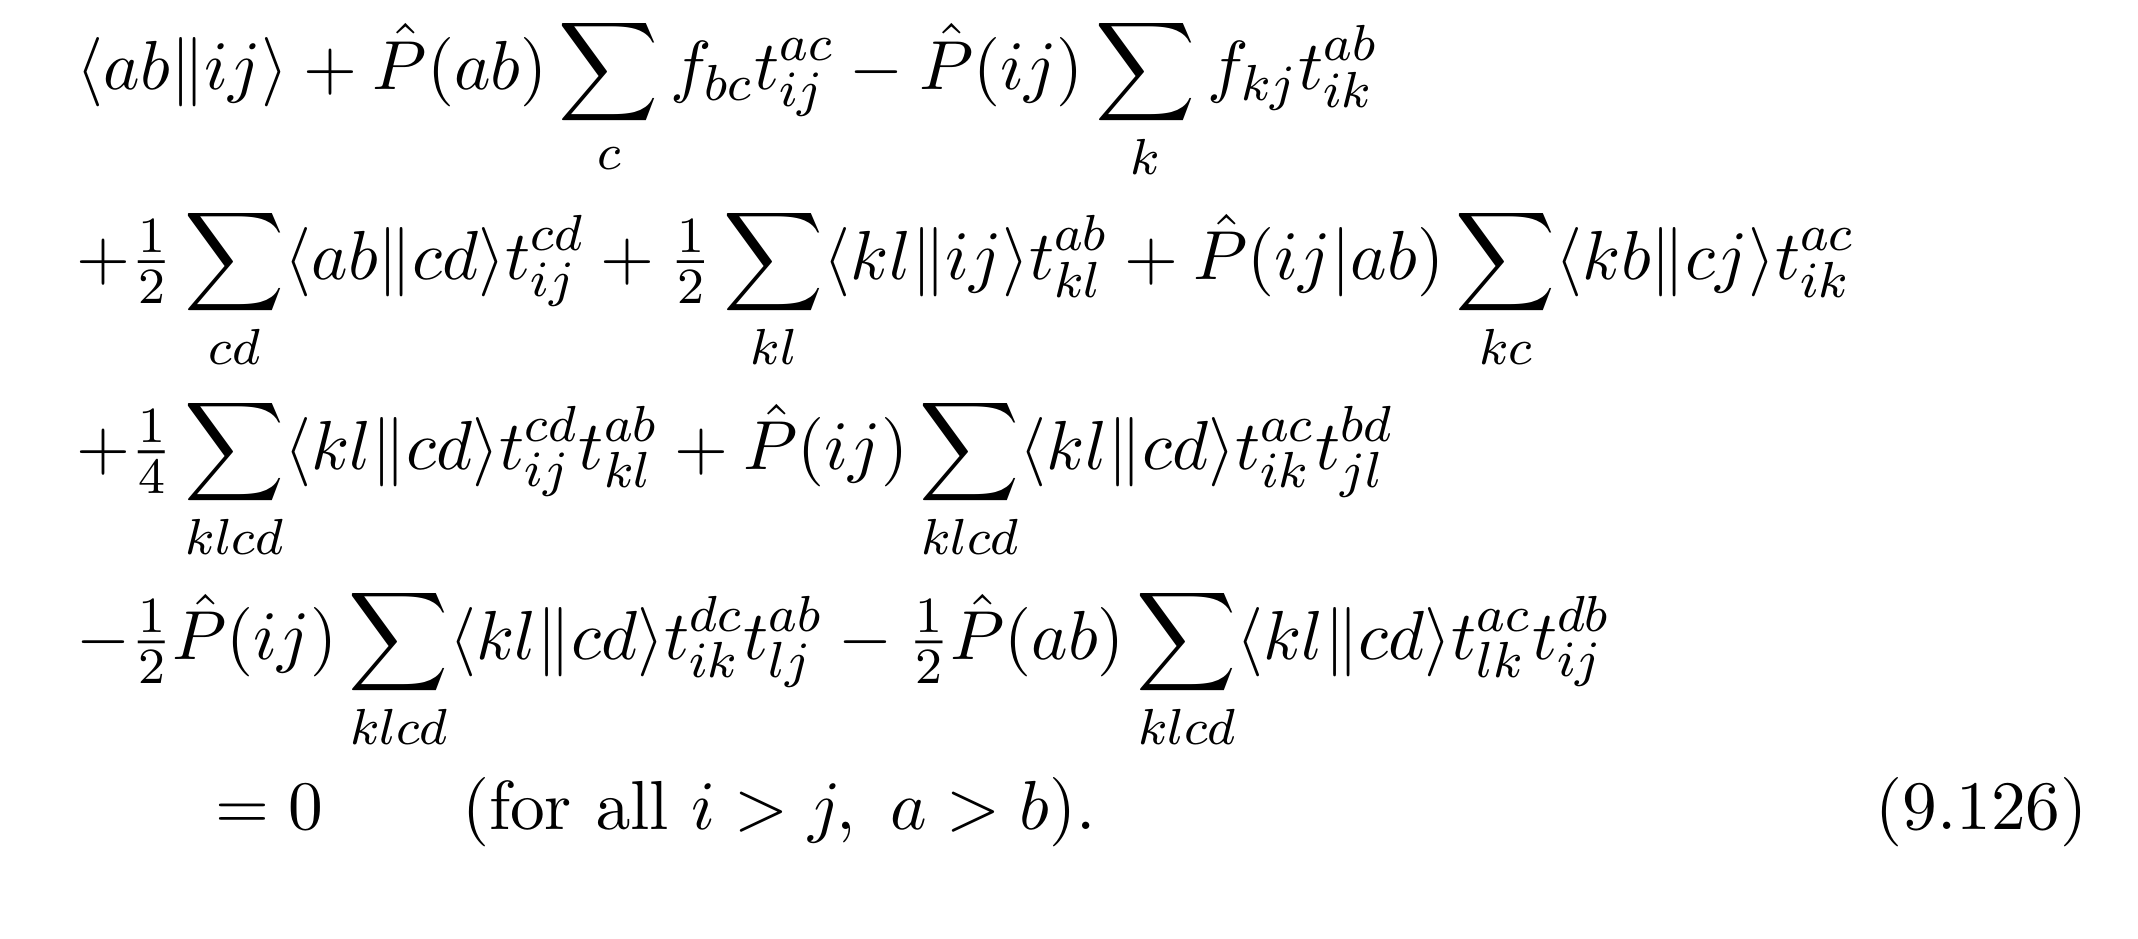

In [285]:
def ccd_onGHF_bartlett(mol, solution, norb, nelec): # debug this
    nocc = nelec
    nvirt = 2*norb - nocc # unrestricted

    t2 = np.zeros((nocc,nocc,nvirt,nvirt)) # like ijab

    mo_coeff = solution[3]
    fock = solution[2]
    fock_mo = mo_coeff.T @ fock @ mo_coeff

    mo_energy = np.diag(mo_coeff.T @ fock @ mo_coeff)

    # initial guess is supposed to be the same as previous; <ij||ab>/Dijab

    T = mol.intor("int1e_kin")
    Vnuc = mol.intor("int1e_nuc")
    hcore = T+Vnuc

    S = mol.intor("int1e_ovlp")
    h2e = mol.intor('int2e', aosym = "s1")

    hcore_ab = np.zeros((2*norb,2*norb))
    hcore_ab[:norb,:norb] = hcore
    hcore_ab[norb:,norb:] = hcore

    S_ab = np.zeros((2*norb,2*norb))
    S_ab[:norb,:norb] = S
    S_ab[norb:,norb:] = S

    h2e_ab = np.zeros((2*norb,2*norb,2*norb,2*norb))
    h2e_ab[:norb,:norb,:norb,:norb] = h2e
    h2e_ab[norb:,norb:,norb:,norb:] = h2e
    h2e_ab[:norb,:norb,norb:,norb:] = h2e
    h2e_ab[norb:,norb:,:norb,:norb] = h2e


    # now we want to transform hcore_ab and h2e_ab from AO-->MO basis.

    hcore_mo = np.einsum('ij,ia,jb->ab',hcore_ab,mo_coeff, mo_coeff)
    h2e_mo = np.einsum('ijkl,ia,jb,kc,ld->abcd', h2e_ab, mo_coeff,mo_coeff,mo_coeff,mo_coeff)

    h2e_mo_asym_chemist = h2e_mo - np.transpose(h2e_mo,(0,3,2,1)) # ai bj (normal) - aj bi (reshaped)

    # now transpose to physicist notation to match bartlett
    # a i b j --> a b i j; transpose(h2e_mo, (0, 2, 1, 3)
    h2e_mo_asym = np.transpose(h2e_mo_asym_chemist,(0, 2, 1, 3))  ## now these are < ab || ij >

    h2e_mo_asym_trunc = h2e_mo_asym[:nocc, :nocc, nocc:, nocc:]


    # t2 amplitudes antisymmetric upon pp/hh transformation
    # we need to generate our t2 guess

    # t2 has dimensions (i,j,a,b) = (occ, occ, vir, vir) = (nelec, nelec, nvirt, nvirt)

    mo_energy_occ = mo_energy[:nocc]
    mo_energy_vir = mo_energy[nocc:]

    denom = mo_energy_occ[:,None,None,None] + mo_energy_occ[None, :, None, None] - mo_energy_vir[None, None, :, None] - mo_energy_vir[None, None, None, :]

    t2 = h2e_mo_asym_trunc / denom

    converged = False

    Eccd_prev = None

    while not converged:

        lhs = (h2e_mo_asym[:nocc, :nocc, nocc:, nocc:] + 0.5*np.einsum('abcd,ijcd->ijab',h2e_mo_asym[nocc:,nocc:,nocc:,nocc:],t2) + 
            0.5 * np.einsum('klij,klab->ijab',h2e_mo_asym[:nocc,:nocc,:nocc,:nocc],t2) + np.einsum('kbcj,ikac->ijab',h2e_mo_asym[:nocc,nocc:,nocc:,:nocc],t2) +
            np.einsum('kaci,jkbc->ijab',h2e_mo_asym[:nocc,nocc:,nocc:,:nocc],t2) - np.einsum('kacj,ikbc->ijab',h2e_mo_asym[:nocc,nocc:,nocc:,:nocc], t2) -
                np.einsum('kbci,jkac->ijab',h2e_mo_asym[:nocc,nocc:,nocc:,:nocc],t2) + 0.25 * np.einsum('klcd,ijcd,klab->ijab',h2e_mo_asym[:nocc,:nocc,nocc:,nocc:], t2, t2) +
                np.einsum('klcd,ikac,jlbd->ijab',h2e_mo_asym[:nocc,:nocc,nocc:,nocc:],t2,t2) - np.einsum('klcd,jkac,ilbd->ijab',h2e_mo_asym[:nocc,:nocc,nocc:,nocc:], t2, t2) - 
                0.5 * np.einsum('klcd,ikdc,ljab->ijab',h2e_mo_asym[:nocc,:nocc,nocc:,nocc:],t2,t2) + 0.5*np.einsum('klcd,jkdc,liab->ijab',h2e_mo_asym[:nocc,:nocc,nocc:,nocc:], t2, t2) -
                0.5 * np.einsum('klcd,lkac,ijdb->ijab',h2e_mo_asym[:nocc,:nocc,nocc:,nocc:], t2, t2) + 0.5*np.einsum('klcd,lkbc,ijda->ijab',h2e_mo_asym[:nocc,:nocc,nocc:,nocc:], t2, t2))
        
        t2 = lhs/denom

        Eccd = 0.25*np.einsum('ijab, ijab->',h2e_mo_asym[:nocc,:nocc,nocc:,nocc:], t2)

        if Eccd_prev is not None:
            if np.abs(Eccd - Eccd_prev) < 1e-8:
                converged = True

        Eccd_prev = Eccd

        print(Eccd)
    
    return Eccd, t2


In [293]:
ccd_onGHF_bartlett(mol, soln, 6, 3)

-0.024696038444641237
-0.02694900745427213
-0.02795855154466296
-0.028482823817195968
-0.02878494116479715
-0.028971058727777027
-0.029090541614047147
-0.029169211935892503
-0.02922182640970461
-0.02925736071636008
-0.02928150933493888
-0.029297986833753235
-0.02930926040773134
-0.02931698797678435
-0.02932229207906756
-0.02932593651368795
-0.029328442691230174
-0.029330167351944318
-0.029331354958921294
-0.029332173232860664
-0.029332737349749758
-0.02933312646315945
-0.029333395007037362
-0.02933358043844256
-0.029333708547056088
-0.029333797099178365
-0.029333858340432666
-0.0293339007157128
-0.02933393005188225
-0.02933395037149187
-0.029333964452933643
-0.029333974216246395


(-0.029333974216246395,
 array([[[[-0.00000000e+00, -2.53622298e-17, -3.44805388e-17,
            2.07869719e-17,  7.69224534e-18, -5.76282626e-18,
            1.05419242e-16, -2.04041301e-17, -1.61724952e-17],
          [ 2.53622298e-17, -0.00000000e+00,  4.85761465e-20,
           -1.92834816e-18, -4.46922838e-18, -1.14043807e-17,
           -2.56973950e-18, -4.74728777e-18,  6.89555791e-18],
          [ 3.44805388e-17, -4.85761465e-20, -0.00000000e+00,
            1.77831262e-17,  1.73276215e-18,  3.71446897e-18,
           -8.30271215e-18,  1.23784593e-17,  2.98972072e-17],
          [-2.08096898e-17,  1.92834816e-18, -1.77831262e-17,
           -0.00000000e+00,  1.86340965e-17,  1.55973530e-17,
            2.55162838e-18,  1.08947054e-17, -8.07985439e-18],
          [-7.69215687e-18,  4.49186150e-18, -1.73276215e-18,
           -1.86340965e-17, -0.00000000e+00,  1.06588918e-17,
            1.36953420e-18,  4.21806671e-18,  1.80969563e-18],
          [ 5.76346719e-18,  1.14043807e-